# CNN

In [42]:
import glob
import random
import os

import pandas as pd
import numpy as np
from PIL import Image

import torch
from torchvision import datasets
from torch.utils import data as torch_data
from torchvision import transforms
import torch.optim as optim
import torch.nn as nn

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns


## Parameters


In [2]:
learning_rate = 0.001
N_Epochs      = 100
batch_size    = 32
IMAGE_SIZE    = 64

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda



## Get the data


In [3]:
# The base dataset directory
BASE_DIR = '../../data/colours/'


## Display image


Displaying: ../../data/colours\white\white10.jpg


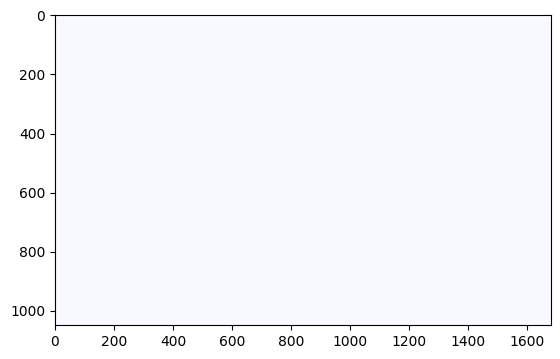

In [4]:
# Get all image paths
# Assuming standard structure: BASE_DIR/Class/Image.jpg
image_paths = glob.glob(os.path.join(BASE_DIR, '*', '*'))

if not image_paths:
    # Fallback if extension is png or other
    image_paths = glob.glob(os.path.join(BASE_DIR, '*', '*'))

if image_paths:
    random_img_path = random.choice(image_paths)
    print('Displaying:', random_img_path)
    plt.imshow(Image.open(random_img_path))
else:
    print(f"No images found in {BASE_DIR}")


In [5]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



## Create Data Loaders


In [6]:
data_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
# Load Dataset using ImageFolder
full_dataset = datasets.ImageFolder(BASE_DIR, transform=train_transform)
N_CLASSES = len(full_dataset.classes)
print('Classes:', full_dataset.classes)
print('Number of classes:', N_CLASSES)

# Split into Train and Test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])


Classes: ['black', 'blue', 'brown', 'green', 'grey', 'orange', 'red', 'violet', 'white', 'yellow']
Number of classes: 10


In [8]:
train_dl = torch_data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dl = torch_data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [29]:
def print_metrics_function(y_test, y_pred):
    """Prints metrics for a classification model and visualizes the confusion matrix."""
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    f1_measure = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    print('F1-mesure: %.3f' % f1_measure)
    return f1_measure



## CNN architecture


In [21]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = (shape,)

    def forward(self, x):
        return x.view(*self.shape)

In [22]:
class Classifier_CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # Conv Layer 1
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2), # 64 -> 32
            
            # Conv Layer 2
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2), # 32 -> 16
            
            # Fully Connected
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 512), # 8192
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, N_CLASSES),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)


In [23]:
def training_loop(N_Epochs, model, loss_fn, opt):

    losses_list = []
    # model = model.to(device) # Handled outside
    print(f"Starting training for {N_Epochs} epochs...")

    for epoch in range(N_Epochs):
        print(f"Epoch {epoch+1}/{N_Epochs} started...")
        batch_count = 0
        running_loss = 0.0

        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device) 
            
            y_pred = model(xb)
            loss = loss_fn(y_pred, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()

            running_loss += loss.item()
            batch_count += 1
            
            # Print every 100 batches to show progress
            if batch_count % 100 == 0:
                print(f"  Batch {batch_count}, Loss: {loss.item():.4f}")

        avg_loss = running_loss / batch_count if batch_count > 0 else 0
        print(f"Epoch {epoch+1} finished. Avg Loss: {avg_loss:.4f}")
        losses_list.append(avg_loss)

    return losses_list


In [13]:
model = Classifier_CNN()
model = model.to(device)

opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

my_losses_list = training_loop(N_Epochs, model, loss_fn, opt)

Starting training for 100 epochs...
Epoch 1/100 started...
Epoch 1 finished. Avg Loss: 2.8704
Epoch 2/100 started...
Epoch 2 finished. Avg Loss: 2.3737
Epoch 3/100 started...
Epoch 3 finished. Avg Loss: 1.7118
Epoch 4/100 started...
Epoch 4 finished. Avg Loss: 1.1572
Epoch 5/100 started...
Epoch 5 finished. Avg Loss: 0.8654
Epoch 6/100 started...
Epoch 6 finished. Avg Loss: 1.0238
Epoch 7/100 started...
Epoch 7 finished. Avg Loss: 0.7287
Epoch 8/100 started...
Epoch 8 finished. Avg Loss: 0.4057
Epoch 9/100 started...
Epoch 9 finished. Avg Loss: 0.7758
Epoch 10/100 started...
Epoch 10 finished. Avg Loss: 0.7176
Epoch 11/100 started...
Epoch 11 finished. Avg Loss: 0.7504
Epoch 12/100 started...
Epoch 12 finished. Avg Loss: 0.7762
Epoch 13/100 started...
Epoch 13 finished. Avg Loss: 0.5017
Epoch 14/100 started...
Epoch 14 finished. Avg Loss: 1.2403
Epoch 15/100 started...
Epoch 15 finished. Avg Loss: 0.7045
Epoch 16/100 started...
Epoch 16 finished. Avg Loss: 0.8503
Epoch 17/100 started..

## Predict and evaluate with trained model on test set

In [43]:
y_pred_list = []
y_real_list = []

with torch.no_grad():
    for x_real, y_real in test_dl:
        x_real = x_real.to(device)
        y_pred = model(x_real)
        vals, indeces = torch.max(y_pred, dim=1)
        y_pred_list.extend(indeces.tolist())
        y_real_list.extend(y_real.tolist())

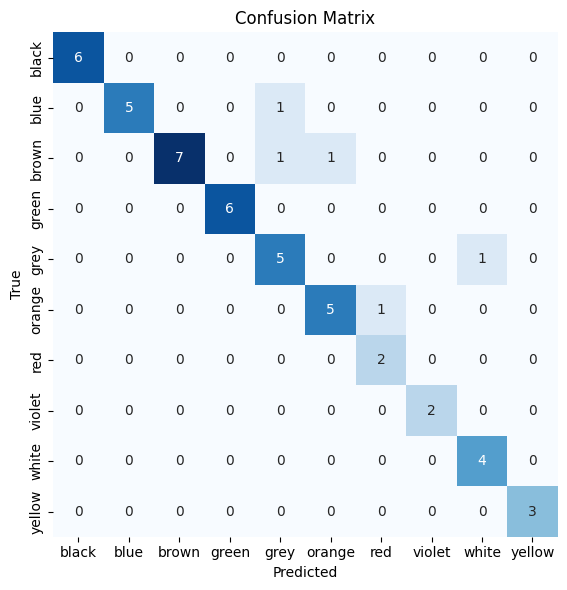

Accuracy: 0.90
Precision: 0.916
Recall: 0.900
F1-mesure: 0.902


np.float64(0.9020097125097125)

In [71]:
# visualize confusion matrix
confmat = confusion_matrix(real_label, pred_label)
plt.figure(figsize=(6, 6))
sns.heatmap(
	confmat, annot=True,
	fmt="d", cmap="Blues",
	xticklabels=full_dataset.classes,
	yticklabels=full_dataset.classes,
	cbar=False, square=True
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


# get all metrics
print_metrics_function(y_real_list, y_pred_list)

## Visualize predictions

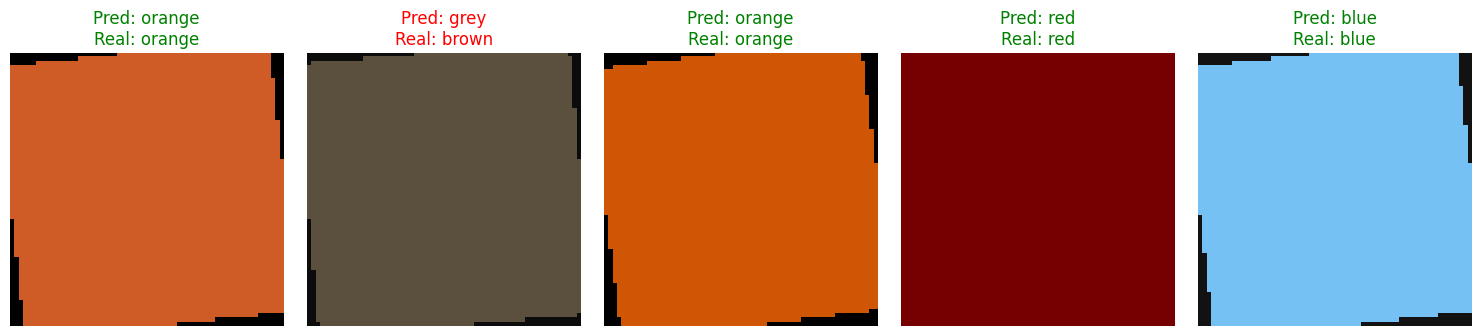

In [53]:
# Visualize predictions
model.eval()
with torch.no_grad():
    x_batch, y_batch = next(iter(test_dl))
    x_batch = x_batch.to(device)
    y_pred = model(x_batch)
    _, preds = torch.max(y_pred, 1)

    plt.figure(figsize=(15, 15))
    for i in range(min(len(x_batch), 5)): # Show up to 5 images
        plt.subplot(5, 5, i+1)
        image = x_batch[i].cpu().permute(1, 2, 0).numpy()
        # Un-normalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        
        plt.imshow(image)
        
        real_label = full_dataset.classes[y_batch[i]]
        pred_label = full_dataset.classes[preds[i]]
        
        color = 'green' if real_label == pred_label else 'red'
        plt.title(f"Pred: {pred_label}\nReal: {real_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()